<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Demand-simulation" data-toc-modified-id="Demand-simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demand simulation</a></span><ul class="toc-item"><li><span><a href="#expected-rewards" data-toc-modified-id="expected-rewards-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>expected rewards</a></span></li><li><span><a href="#sample-draws" data-toc-modified-id="sample-draws-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>sample draws</a></span></li><li><span><a href="#Regression-models-for-demand" data-toc-modified-id="Regression-models-for-demand-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Regression models for demand</a></span></li></ul></li><li><span><a href="#Online-regression" data-toc-modified-id="Online-regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Online regression</a></span><ul class="toc-item"><li><span><a href="#Parametrizations" data-toc-modified-id="Parametrizations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Parametrizations</a></span></li></ul></li><li><span><a href="#Demand-simulation-from-avocado-dataset" data-toc-modified-id="Demand-simulation-from-avocado-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Demand simulation from avocado dataset</a></span></li></ul></div>

in this notebook:
- demand simulation
- online algorithms demonstration

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
import scipy.stats as ss
from bandits.online_models import ConstantModel, SimpleLinearRegressor

## Demand simulation

### expected rewards

In [4]:
p_min = 1
p_max = 10
K = 10
dist_mean = 5
dist_std = 2  # note: I increased it to 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

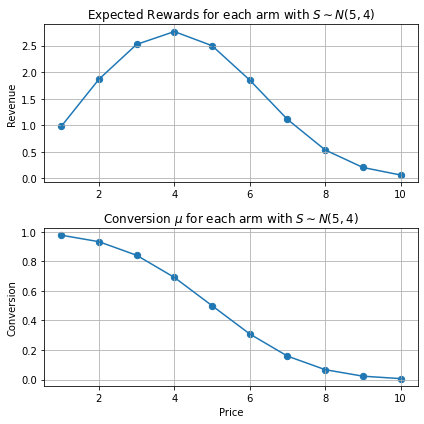

In [5]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

### sample draws

In [6]:
p_min = 1
p_max = 10
K = 10
dist_mean = 5
dist_std = 15
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [7]:
n_customers = 100
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)

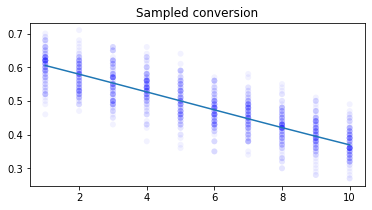

In [8]:
np.random.seed(1)

fig,axs=plt.subplots(figsize=(6, 3))

n_draws_per_arm = 100
for i, mu in enumerate(mus):
    draws = np.random.binomial(n_customers, mu, size=(n_draws_per_arm,))/n_customers
    sns.scatterplot(
        x=np.repeat(arms[i], n_draws_per_arm), y=draws,
        color='blue', edgecolor="none", alpha=0.05);
    
plt.plot(arms, mus)
plt.title('Sampled conversion');

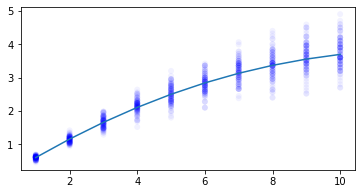

In [9]:
np.random.seed(1)

fig,axs=plt.subplots(figsize=(6, 3))

n_draws_per_arm = 100
for i, mu in enumerate(mus):
    draws = np.random.binomial(n_customers, mu, size=(n_draws_per_arm,))/n_customers
    sns.scatterplot(
        x=np.repeat(arms[i], n_draws_per_arm), y=arms[i]*draws,
        color='blue', edgecolor="none", alpha=0.05);
    
plt.plot(arms, arms*mus);

### Regression models for demand

In [10]:
# note that i do not aggregate the result
def smooth_mape(y, y_pred, s=0.1):
    return np.abs(y-y_pred)/(y+s)

def rmse(y, y_pred, s=0.1):
    return np.sqrt(np.mean((y-y_pred)**2))

In [11]:
p_min = 1
p_max = 10
K = 10
dist_mean = 3
dist_std = 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [12]:
n_customers = 20
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)

In [13]:
# build the dataset
np.random.seed(1)
n_draws_per_arm = 100
conversion_df = []
for i, mu in enumerate(mus):
    draws = np.random.binomial(n_customers, mu, size=(n_draws_per_arm,))/n_customers
    conversion_df.append(draws)

conversion_df = pd.DataFrame(
    np.vstack([np.repeat(arms, n_draws_per_arm), np.hstack(conversion_df)]).T,
    columns=['price', 'conversion']
)
conversion_df = conversion_df.sample(frac=1).reset_index(drop=True) # shuffle
conversion_df['is_train'] = (conversion_df.index < 0.66*len(conversion_df.index)).astype(int)

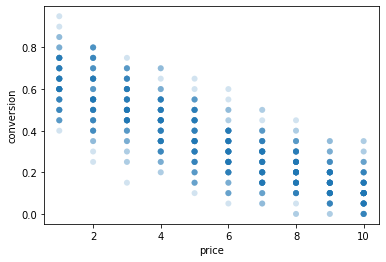

In [14]:
sns.scatterplot(x='price', y='conversion', data=conversion_df, edgecolor='none', alpha=0.2);

In [15]:
train_df = conversion_df[conversion_df['is_train']==1]
val_df = conversion_df[conversion_df['is_train']==0]

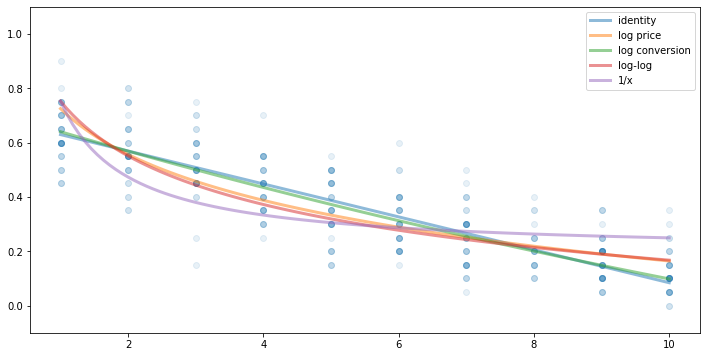

In [16]:
fig,axs=plt.subplots(figsize=(12, 6))

lr_models = [
    ("identity", SimpleLinearRegressor(0, 0)),
    ("log price", SimpleLinearRegressor(0, 0, x_transform=np.log)),
    ("log conversion", SimpleLinearRegressor(0, 0, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("log-log", SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("1/x", SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x)),
]
scores_df = []

for model_name, model in lr_models:
    x = train_df['price']
    y = train_df['conversion']
    model.update_estimates(x, y)
    x_range = np.linspace(x.min(), x.max(), 100)
    y_hat = model.predict(x_range)
    
    plt.plot(x_range, y_hat, label=model_name, lw=3, alpha=0.5)
    plt.legend();
    
    x = val_df['price']
    y = val_df['conversion']
    y_pred = model.predict(x)
    score = rmse(y, y_pred)
    scores_df.append(score)
    
plt.scatter(x, y, alpha=0.1, label='observations')
plt.ylim(-0.1, 1.1);

In [17]:
scores_df = pd.DataFrame([scores_df], columns=[m for m,_ in lr_models], index=['RMSE'])
scores_df

,identity,log price,log conversion,log-log,1/x
RMSE,0.103029,0.109464,0.101904,0.114617,0.135895


here, the log conversion model, $\textit{Q}=e^{a+b \cdot P}$, was the best

lets see a different example:

In [18]:
p_min = 1
p_max = 10
K = 10
dist_mean = 8
dist_std = 10
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [19]:
n_customers = 40
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)

In [20]:
# build the dataset
np.random.seed(1)
n_draws_per_arm = 100
conversion_df = []
for i, mu in enumerate(mus):
    draws = np.random.binomial(n_customers, mu, size=(n_draws_per_arm,))/n_customers
    conversion_df.append(draws)

conversion_df = pd.DataFrame(
    np.vstack([np.repeat(arms, n_draws_per_arm), np.hstack(conversion_df)]).T,
    columns=['price', 'conversion']
)
conversion_df = conversion_df.sample(frac=1).reset_index(drop=True) # shuffle
conversion_df['is_train'] = (conversion_df.index < 0.66*len(conversion_df.index)).astype(int)

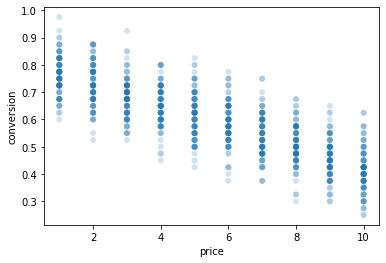

In [21]:
sns.scatterplot(x='price', y='conversion', data=conversion_df, edgecolor='none', alpha=0.2);

In [22]:
train_df = conversion_df[conversion_df['is_train']==1]
val_df = conversion_df[conversion_df['is_train']==0]

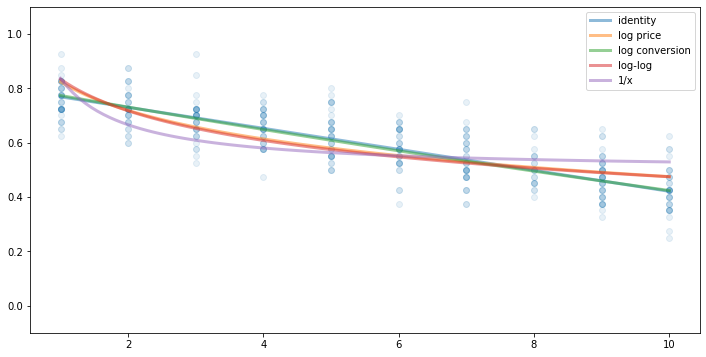

In [23]:
fig,axs=plt.subplots(figsize=(12, 6))

lr_models = [
    ("identity", SimpleLinearRegressor(0, 0)),
    ("log price", SimpleLinearRegressor(0, 0, x_transform=np.log)),
    ("log conversion", SimpleLinearRegressor(0, 0, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("log-log", SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("1/x", SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x)),
]
scores_df = []

for model_name, model in lr_models:
    x = train_df['price']
    y = train_df['conversion']
    model.update_estimates(x, y)
    x_range = np.linspace(x.min(), x.max(), 100)
    y_hat = model.predict(x_range)
    
    plt.plot(x_range, y_hat, label=model_name, lw=3, alpha=0.5)
    plt.legend();
    
    x = val_df['price']
    y = val_df['conversion']
    y_pred = model.predict(x)
    score = rmse(y, y_pred)
    scores_df.append(score)
    
plt.scatter(x, y, alpha=0.1, label='observations')
plt.ylim(-0.1, 1.1);

In [24]:
scores_df = pd.DataFrame([scores_df], columns=[m for m,_ in lr_models], index=['RMSE'])
scores_df

,identity,log price,log conversion,log-log,1/x
RMSE,0.076009,0.084066,0.07635,0.085934,0.100242


here the identity parametrization ($Q=aP+b$) is the best

## Online regression

In [25]:
%matplotlib notebook

In [26]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

<IPython.core.display.Javascript object>


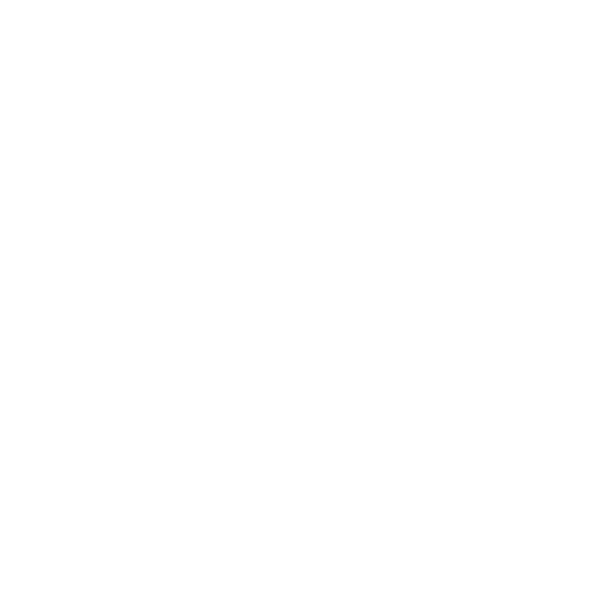

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_xlim(-0.3, 10.3)
ax.set_ylim(-0.1, 1.1)
scatter, = ax.plot([], [], 'bo', label='observation', alpha=0.1)
line, = ax.plot([], [], 'r', label='Linear Regression')
ax.legend()
plt.title('Online linear regression')
plt.xlabel('x')
plt.ylabel('y')


x_data = []
y_data = []
model = SimpleLinearRegressor(0, 0)
x = conversion_df['price']
y = conversion_df['conversion']

def animate(frame_num):
    x_data.append(x[frame_num])
    y_data.append(y[frame_num])
    x_train = np.array(x_data)
    y_train = np.array(y_data)
    
    model.update_estimates(np.array([x[frame_num]]), np.array([y[frame_num]]))
    x_range = np.linspace(x.min(), x.max(), 100)
    y_hat = model.predict(x_range)
    
#     plt.plot(x_range, y_hat, lw=1, alpha=0.5)

    scatter.set_data((x_data, y_data))
    line.set_data((x_range, y_hat))

anim = FuncAnimation(fig, animate, frames=50, interval=10, repeat=True, blit=True)
writer = PillowWriter(fps=5)  
anim.save(f"../images/online_lr.gif", writer=writer) 
plt.show()

In [28]:
%matplotlib inline

### Parametrizations

In this subsection, different regression parametrizations are shown

In [29]:
T = 2500

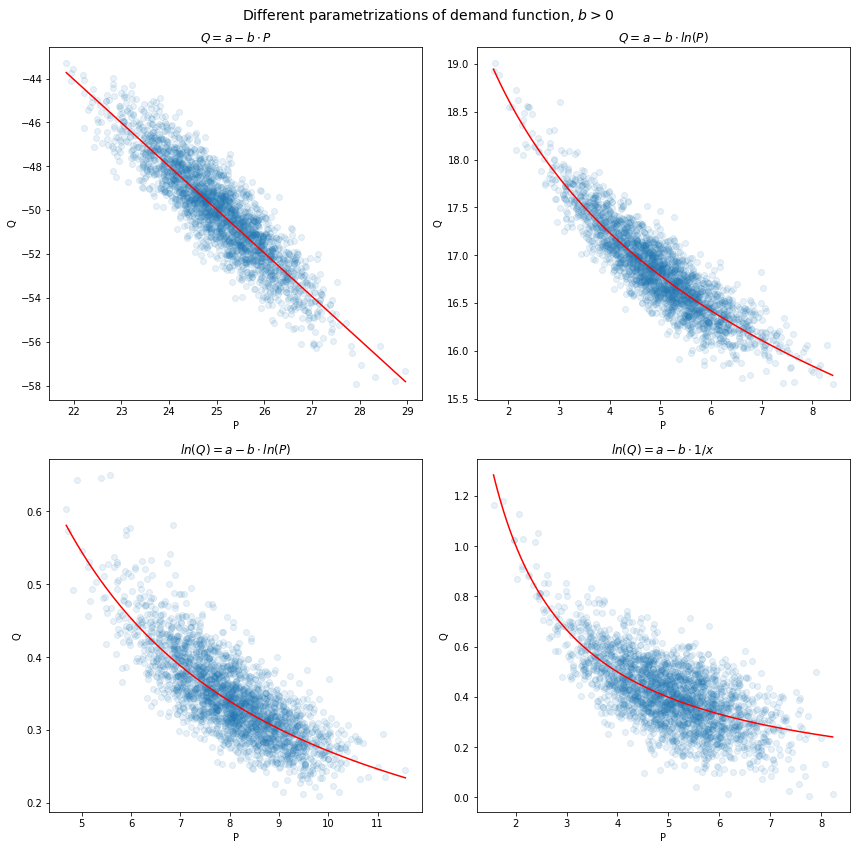

In [30]:
fig,axs=plt.subplots(figsize=(12, 12))

fig.suptitle('Different parametrizations of demand function, $b>0$', fontsize=14)

plt.subplot(2, 2, 1)
np.random.seed(1)
x = np.random.normal(size=(T,), loc=25, scale=1)
y = -2 * x  + np.random.normal(size=(T,), loc=0, scale=1)
slr = SimpleLinearRegressor()
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$Q=a-b \cdot P$');

plt.subplot(2, 2, 2)
x = np.random.normal(size=(T,), loc=5, scale=1)
y = 20-np.log(x) * 2 + np.random.normal(size=(T,), loc=0, scale=0.2)
slr = SimpleLinearRegressor(x_transform=np.log)
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$Q=a-b \cdot ln(P)$');

plt.subplot(2, 2, 3)
x = np.random.normal(size=(T,), loc=8, scale=1)
y = np.exp(1-1*np.log(x) + np.random.normal(size=(T,), loc=0, scale=0.1))
slr = SimpleLinearRegressor(x_transform=np.log, y_transform=np.log, y_inv_transform=np.exp)
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$ln(Q)=a-b \cdot ln(P)$');

plt.subplot(2, 2, 4)
x = np.random.normal(size=(T,), loc=5, scale=1)
y = 2 * 1/(x) + np.random.normal(size=(T,), loc=0, scale=0.1)
slr = SimpleLinearRegressor(x_transform=lambda x: 1/x)
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$ln(Q)=a-b \cdot 1/x$');

fig.tight_layout();

## Demand simulation from avocado dataset

In [31]:
import os
import warnings

In [32]:
from bandits.pricing.bandits import get_avocado_df, PricingAvocadoBanditEnv

In [33]:
base_dir = '../data/avocado/'
os.listdir(base_dir)

['avocado.csv', 'avocado-prices.zip']

In [34]:
avocado_path = os.path.join(base_dir, 'avocado.csv')

In [35]:
avocado_df = get_avocado_df(avocado_path)
K = 10
region = 'DallasFtWorth'
start_date = pd.to_datetime('2018-01-01')
T = 360

In [36]:
# just choosing random prices as actions
np.random.seed(1)
sampled_prices = np.random.choice(range(K), size=T)

In [37]:
from bandits.pricing.bandits import get_avocado_df, PricingAvocadoBanditEnv

In [38]:
env = PricingAvocadoBanditEnv(
    num_arms=K, avocado_df=avocado_df, region=region, start_date=start_date
)

In [39]:
# just choosing random prices as actions
np.random.seed(1)
sampled_prices = np.random.choice(range(K), size=T)

In [40]:
quantity = []
for i in tqdm(range(T)):
    action = sampled_prices[i]
    observation, reward, done, info = env.step(action)
    # print('step', observation, reward, done, info)
    quantity.append(reward/env.action_to_price[action])

  0%|          | 0/360 [00:00<?, ?it/s]

In [41]:
run_df = pd.DataFrame(np.array([sampled_prices, quantity]).T, columns=['price_unmapped', 'quantity'])
run_df['price'] = run_df['price_unmapped'].map({i: j for i,j in enumerate(env.action_to_price)})
run_df['rev'] = run_df['price'] * (run_df['quantity'])

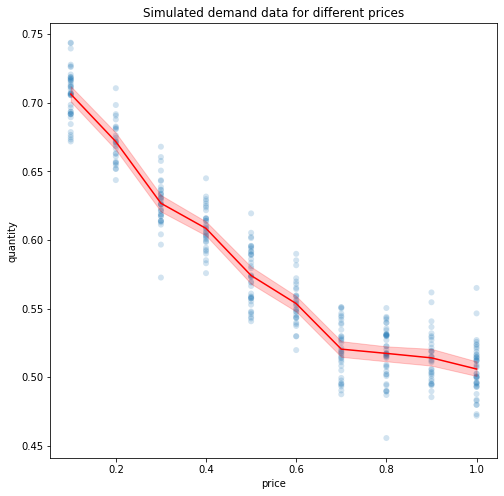

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='price', y='quantity', data=run_df, edgecolor='none', alpha=0.2)
sns.lineplot(x='price', y='quantity', data=run_df, color='red')
plt.title('Simulated demand data for different prices');

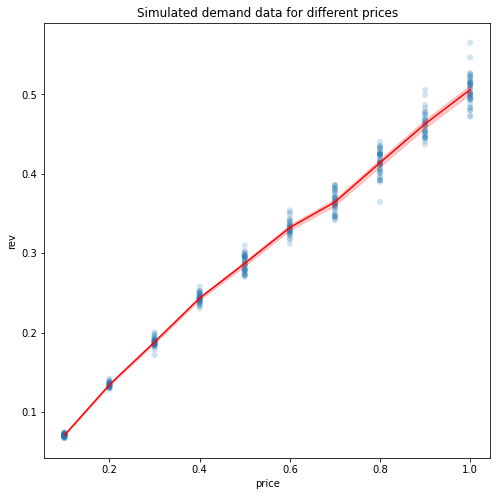

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='price', y='rev', data=run_df, edgecolor='none', alpha=0.2)
sns.lineplot(x='price', y='rev', data=run_df, color='red')
plt.title('Simulated demand data for different prices');